In [1]:
import os
import sys
sys.path.append('../')
sys.path.append('../datasets')
sys.path.append('../models')
import torch
import torchvision
import torch.backends.cudnn as cudnn
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from importlib import reload
from datasets.three_dim_shapes import ThreeDimShapesDataset
from datasets.small_norb import SmallNORBDataset
from datasets.seq_mnist import SequentialMNIST
from datasets.seq_mnist import SequentialMNIST_double
from datasets import seq_mnist as sm

import models.seqae as seqae
import models.base_networks as bn 
import models
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from einops import rearrange
from sklearn.metrics import r2_score
import pdb
from einops import rearrange
from utils import notebook_utils as nb
from utils import evaluations as ev



import copy

import csv
import ast
from source import yaml_utils as yu


from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    gpu_index = -1

    
from utils import yaml_utils as yu
import yaml
rootpath = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/'
result_dir = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result'
jobdir = '/mnt/vol21/masomatics/ULASclone/jobs'

mode = 'so3'
dat_root = f"""/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/{mode}"""

playground_path = os.path.join(result_dir, '20220913_playground_model')


print(os.path.exists(playground_path))

default_file =  '20220926_default_run_mnist'
default_path = os.path.join(result_dir, default_file)

True


In [2]:
data_args = nb.load_config(default_path)['train_data']['args']
data_args['T'] = 10


In [3]:
default_dat = SequentialMNIST(**data_args)


/usr/local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


/tmp/ipykernel_660/435866126.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(datseq[k]).permute([1, 2, 0 ]))


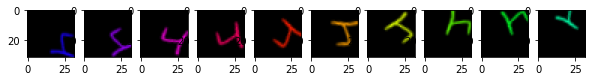

In [4]:
datseq = default_dat[0]
plt.figure(figsize=(10, 10))
for k in range(len(datseq)):
    plt.subplot(1, len(datseq), k+1 )
    plt.imshow(torch.tensor(datseq[k]).permute([1, 2, 0 ]))

In [5]:
data_args

{'T': 10,
 'backgrnd': False,
 'max_T': 9,
 'max_angle_velocity_ratio': [-0.5, 0.5],
 'max_color_velocity_ratio': [-0.5, 0.5],
 'only_use_digit4': True,
 'root': '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/MNIST',
 'train': True}

In [6]:
# train_path = os.path.join(result_dir, '20221101_mnist_double_0', 'dim_m312')
# data_args = nb.load_config(train_path)['train_data']['args']

config = nb.load_config('/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20221101_mnist_double_0/dim_m312')
data_args = config['train_data']['args']
print(data_args)


data_args['train'] = True
data_args['T'] = 10


{'T': 3, 'backgrnd': False, 'max_T': 9, 'max_angle_velocity_ratio': [-0.5, 0.5], 'max_color_velocity_ratio': [-0.5, 0.5], 'only_use_digit4': True, 'root': '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/MNIST', 'train': True}


In [18]:
reload(sm)
double_dat = sm.SequentialMNIST_double(pair_transition=False, same_object=True, **data_args)
unko = double_dat.__getitem__(0)



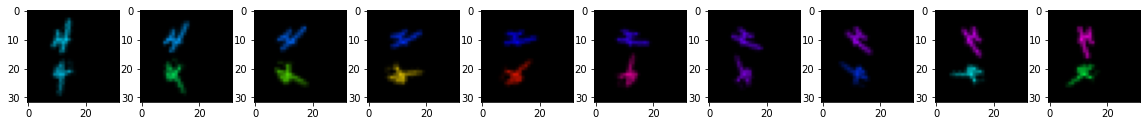

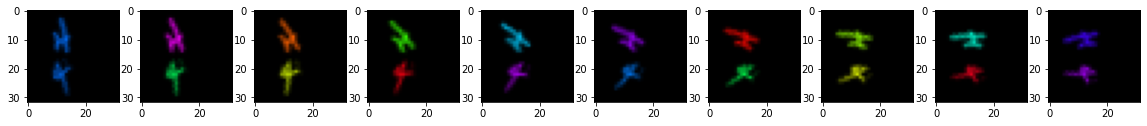

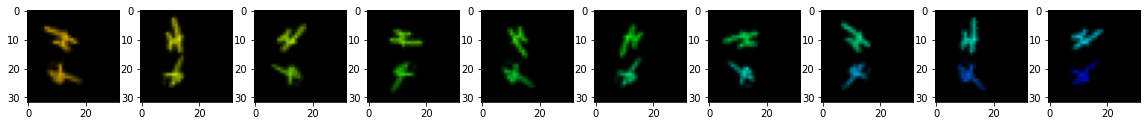

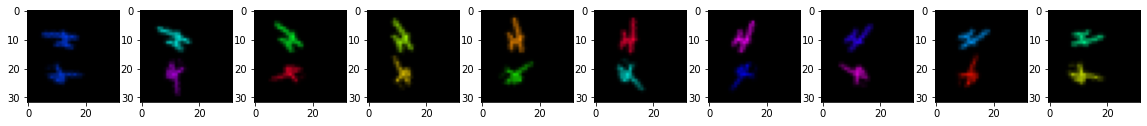

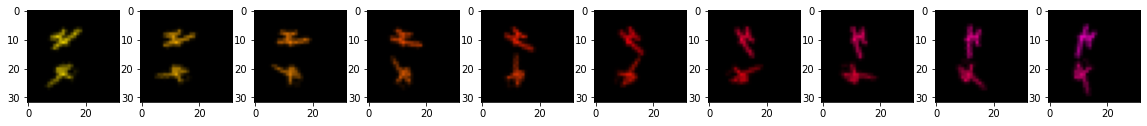

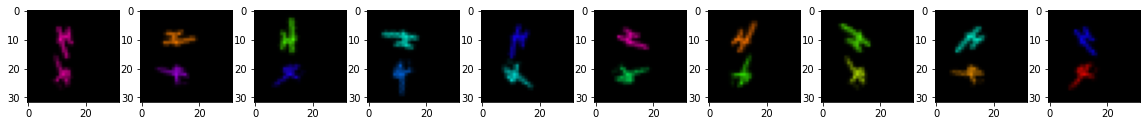

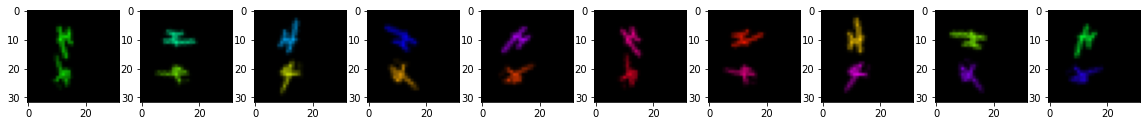

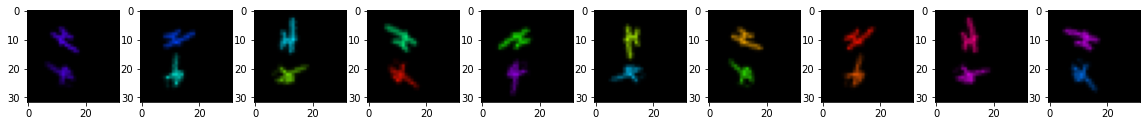

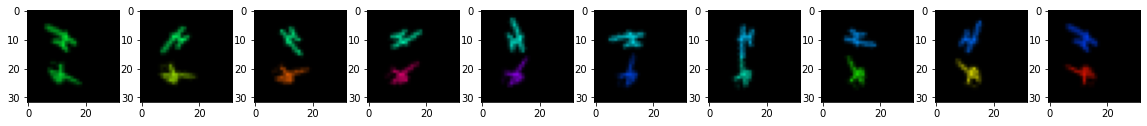

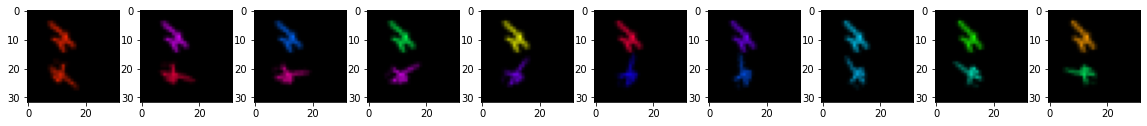

In [19]:

size = 10
for j in range(size):
    plt.figure(figsize=(20, 20))
    datseq = double_dat[j]
    for k in range(len(datseq)):
        plt.subplot(size, len(datseq),  k+1)
        plt.imshow(torch.tensor(datseq[k]).permute([1, 2, 0])) 

In [62]:
print(len(double_dat.first_indices))
double_dat.first_indices[0:10]
double_dat.pairpos0, double_dat.pairpos1

5842


([array([-4.44810926,  5.9317169 ]), array([-4.69249351,  6.69777453])],
 [array([-4.01038611, -6.21961682]), array([8.62280464, 3.90062484])])

In [124]:
from utils import misc as ms
from skimage.transform import resize
import cv2
import math
import colorsys

In [125]:
movemat = ms.get_RTmat(0, 0, 0.1, 32, 32, -3, -2)

8
(16, 16)
(32, 32)
[0.09952155] [-3.01937135  2.60530712] [-0.01492988 -2.75203354] [2.51920988]


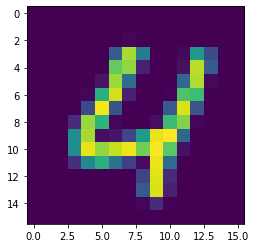

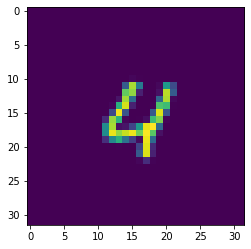

In [222]:
original_size = 28
digit_size = 16
margin = int((32 - digit_size)/2)
idx = 8

image = np.array(double_dat.data[idx][0], np.float32).reshape(original_size, original_size)
#image = np.array(bckcheck[:28, :28], np.float32).reshape(original_size, original_size)
image = resize(image, [digit_size , digit_size])
plt.figure()
plt.imshow(image)
print(margin)
print(image.shape)
image = cv2.copyMakeBorder(
    image, margin , margin , margin , margin , cv2.BORDER_CONSTANT, value=(0, 0, 0))
plt.figure()
plt.imshow(image)
print(image.shape)

np.random.seed(10)
angles_0 = np.random.uniform(0, 2 * math.pi, size=1)
color_0 = np.random.uniform(0, 1, size=1)

angles_v = np.random.uniform(
    math.pi * -3,
    math.pi * 3, size=1)
angles_a = 0
color_v = 0.2 * np.random.uniform(-1, 1 ,size=1)
color_a = 0

pos1= np.random.uniform(-5, 5, size=[2])
pos0= np.random.uniform(-5, 5, size=[2])

pos_v = (pos1 - pos0) / (5 - 1)


print(color_v, pos0, pos1, angles_v)

[0.02075195] [2.32714065] [-3.01937135  2.60530712]
[0.1202735] [4.84635053] [-3.01937135  2.60530712]
[0.21979506] [7.36556041] [-3.01937135  2.60530712]


/tmp/ipykernel_74/1716037969.py:14: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  rgb = np.asarray(colorsys.hsv_to_rgb(


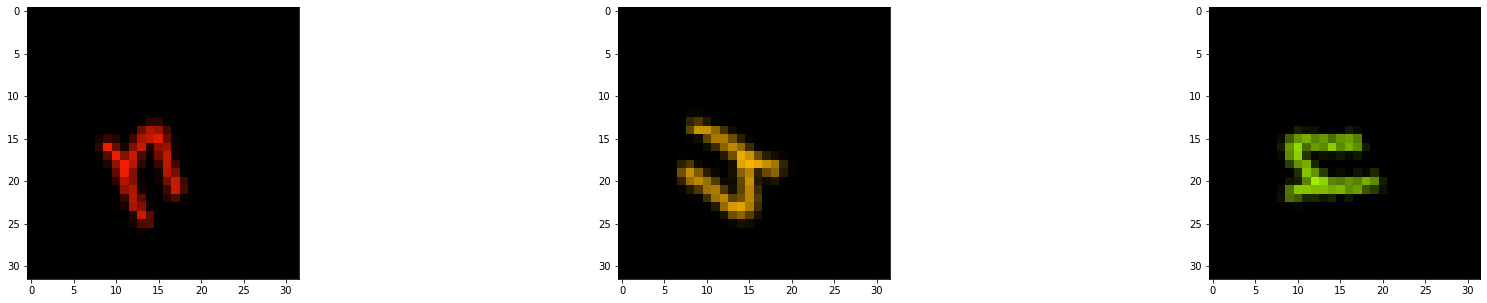

In [223]:
myT = 3
t = 0

plt.figure(figsize=(30, 5))
for t in range(myT):
    angles_t = angles_v * (t-1) + angles_0
    #pos_t = pos_v * t + pos0
    pos_t = pos0
    color_t = (t * color_v + color_0) % 1
    print(color_t, angles_t, pos_t)
    
    mat = ms.get_RTmat(0, 0, float(angles_t), 32, 32, pos_t[0],
                    pos_t[1])
    rgb = np.asarray(colorsys.hsv_to_rgb(
        color_t, 1, 1), dtype=np.float32)

    _image = cv2.warpPerspective(image.copy(), mat, (32, 32))
    _image = np.concatenate(
        [_image[:, :, None]] * 3, axis=-1) * rgb[None, None]
    _image = _image / 255.

    plt.subplot(1, myT, t + 1)
    plt.imshow(_image)

In [196]:
mat

array([[ 12.02334746, -22.627417  , 518.27352428],
       [ 22.627417  ,  12.02334746, -61.68018556],
       [  0.        ,   0.        ,  26.62344403]])

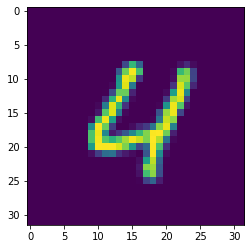

In [140]:
plt.imshow(image)

[[45.254834  0.       16.      ]
 [ 0.       45.254834 16.      ]
 [ 0.        0.       46.254834]]
[[  14.52889737  -22.627417    575.82129988]
 [  22.627417     14.52889737 -148.25604405]
 [   0.            0.           27.89031162]]
[[-10.35560832 -22.627417   941.88049631]
 [ 22.627417   -10.35560832 217.80315238]
 [  0.           0.          25.8845057 ]]


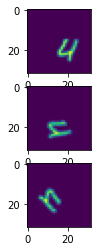

In [171]:
reload(ms)
for t in range(3):
    mat = ms.get_RTmat(0, 0, t*1.0, 32, 32, 0, 0)
    print(mat)
    _image = cv2.warpPerspective(image.copy(), mat, (32, 32))
    plt.subplot(3, 1, t+1)
    plt.imshow(_image)

# Verifying the dataset called in evaluation 

In [247]:
root= '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/MNIST'
fname = "MNIST/test_dat.pt"
bckdat = torch.load(os.path.join(root, fname))

In [251]:
dataconfig = config['train_data']
tp = 17
n_cond =2 
dataconfig['args']['T'] = tp + n_cond
dataconfig['args']['train'] = False
dataconfig['args']['max_T'] = tp + n_cond
data = yu.load_component(dataconfig)
train_loader = DataLoader(data,
                          batch_size=config['batchsize'],
                          shuffle=True,
                          num_workers=config['num_workers'])

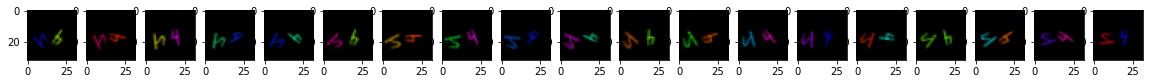

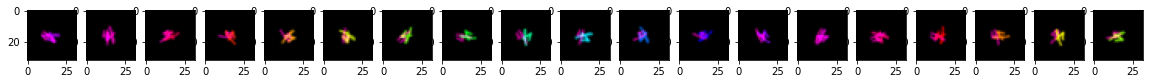

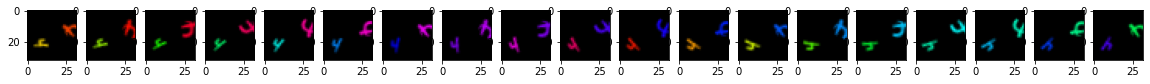

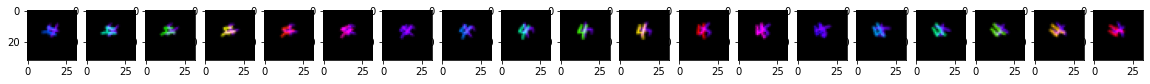

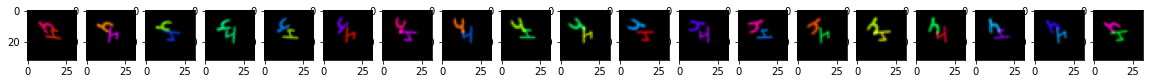

In [264]:
images = next(iter(train_loader))
for idx in range(5): 
    plt.figure(figsize=(20,20))
    for k in range(len(images)):
        plt.subplot(1, len(images), k+1)
        plt.imshow(images[k][idx].permute([1, 2, 0]))

In [261]:
images[0].shape

torch.Size([32, 3, 32, 32])

In [262]:
config['batchsize']

32

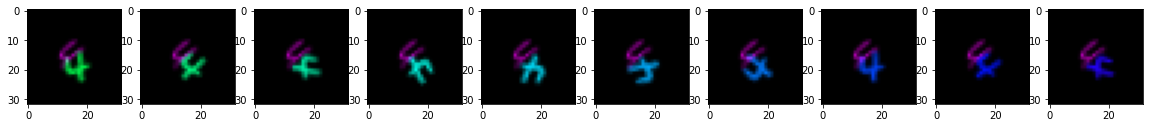

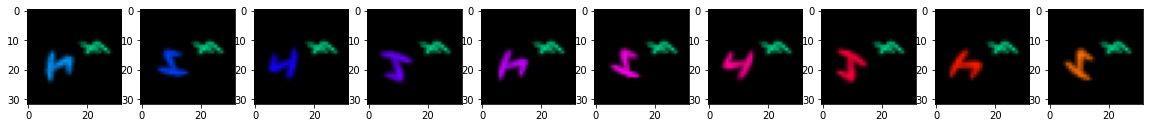

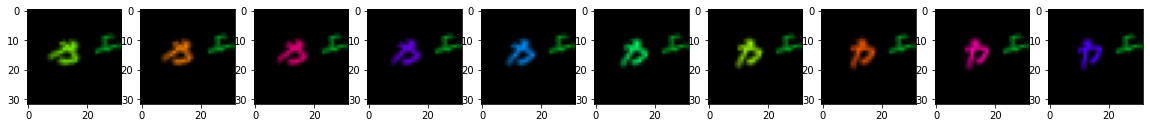

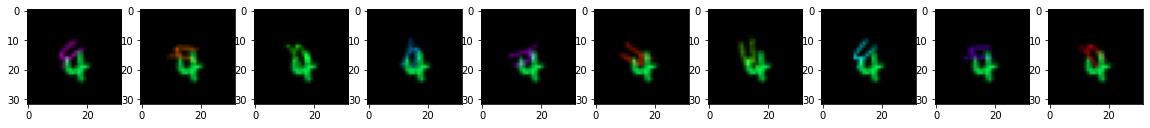

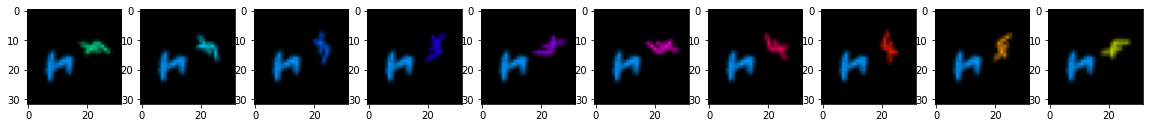

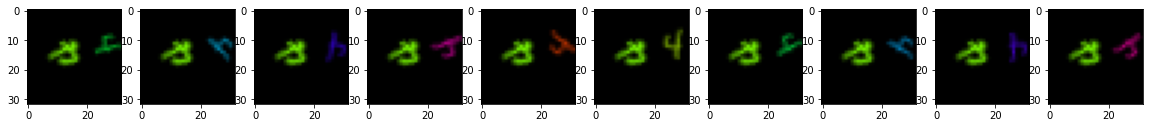

In [294]:
reload(sm)
np.random.seed(0)
double_dat = sm.SequentialMNIST_double(**data_args)
np.random.seed(0)
size = 3
shift = 2
for j in range(shift, size+shift):
    plt.figure(figsize=(20, 20))
    datseq = double_dat.one_obj_immobile(j)
    for k in range(len(datseq)):
        plt.subplot(size, len(datseq),  k+1)
        plt.imshow(torch.tensor(datseq[k]).permute([1, 2, 0])) 
        
np.random.seed(0)
size = 3
for j in range(shift, size+shift):
    plt.figure(figsize=(20, 20))
    datseq = double_dat.one_obj_immobile(j, mode=0)
    for k in range(len(datseq)):
        plt.subplot(size, len(datseq),  k+1)
        plt.imshow(torch.tensor(datseq[k]).permute([1, 2, 0])) 

In [272]:
images = iter(train_loader).next()
# Initialize lazy modules
if type(images) == list:
    images = torch.stack(images)
    images = images.transpose(1, 0)

images = images.to(device)
images_cond = images[:, :n_cond]
print(images[:, :n_cond].shape)

torch.Size([32, 2, 3, 32, 32])


In [271]:
import einops

"torch.einsum('b h n m, b h m d -> b n h d', prob, v)""

In [277]:
unko= torch.tensor(np.random.normal(size=(3,3))).float()
unpoko = torch.tensor(np.random.normal(size=).float()
trial = torch.einsum('b t c w h, c k -> b t k w h', images_cond.to('cpu').float(), unko)
trial.shape

torch.Size([32, 2, 3, 32, 32])

In [278]:
trial[0, 1, :, 3 ,5]

tensor([0., 0., 0.])

In [279]:
unko

tensor([[ 0.1341, -0.6032, -0.4426],
        [ 0.1425,  1.2537, -0.9424],
        [ 2.3464, -0.7699, -0.7550]])

In [282]:
trial[0, 1, :, 3, :]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])